#LSTM CNN con database MNIST

Se il layer LSTM aveva la versione ottimizzata CUDA CuDNNLSTM, il layer convoluzionale LSTM, cioè `ConvLSTM2D`, non ne presenta (ancora) uno ([issue aperto](https://github.com/keras-team/keras/issues/11356)).

In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf
from tensorflow import keras as ks

print(tf.__version__)

1.15.2


In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


##Definizione metodi

In [0]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


##ConvLSTM layer input

([Intro a ConvLSTM](https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7)).

L'input di LSTM cell consiste di insiemi di dati nel tempo, ossia un tensore 3D della forma `[samples, time_steps, features]`.

L'input del layer convoluzionale è un insieme di immagini come un tensore 4D della forma `[samples, channels, rows, cols]`.

L'input di una ConvLSTM è un insieme di immagini nel tempo, ossia un tensore 5D della forma `[samples, time_steps, channels, rows, cols]` (o `[samples, time, rows, cols, channels]` se `data_format = channel_last`, default).


##ConvLSTM layer output
L'output di LSTM cell dipende dall'attributo return_sequences. Se true, l'output è un tensore 3D della forma `[samples, time_steps, features]`, altrimenti è `[samples, features]`.

L'output del layer convoluzionale è un tensore 4D della forma `[samples, filters, rows, cols]`.

L'output del layer ConvLSTM è una combinazione dei layer precedenti, quindi se return_sequences è true, ritorna un tensore 5D della forma `[samples, time_steps, filters, rows, cols]`; se false, è un tensore 4D `[samples, filters, rows, cols]`.

##Altri parametri
I parametri manipolabili derivano dai parametri dei layer convoluzionali e dei layer LSTM.

Abbiamo, rispettivamente al convolutional layer:


*   filters, numero di output filters;
*   kernel_size;
*   padding;
*   data_format;
*   activation, activation function; di default è funzione lineare.

Rispetto al LSTM layer, si ha:

*   recurrent_activation, funzione di attivazione per il recurrent step;
*   return_sequences.


#Import database

In [0]:
#Import del database MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in train set: " + str(len(test_labels)))

print("Done")

11493376/11490434 [==============================] - 0s 0us/step
Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in train set: 10000
Done


#Modello

Posso costruire il modello in due modi.

##Modo 1

Il primo modo consiste nel creare un modello convoluzionale, farne un wrapping nella classe TimeDistributed ed usarlo per costruire una rete LSTM.

Un altro approccio a tale modo consiste nel fare il wrap di ogni layer nel modello CNN in un layer TimeDistributed che viene poi aggiunto al modello LSTM.

[Qui](https://machinelearningmastery.com/cnn-long-short-term-memory-networks/) un esempio.

##Modo 2
Il secondo è quello di utilizzare la classe ConvLSTM2D; la classe necessita un tensore di 5 dimensioni, della forma [samples, time, rows, cols, channels].

Se nella CNN avevo:

```
input_shape=(28, 28, 1)
```
 e nella LSTM avevo:

```
input_shape=(time_steps, n_features)
```

nella ConvLSTM2D avrò (con channel last):

```
input_shape = (time_steps, 28, 28, 1)
```


#Preprocessing dei dati

In [0]:
#Costanti
batch_size = 128
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

time_steps = 4
n_features = 7
size_ts_blocks = 4
rows = 28
cols = 28

print("Done")

Done


In [0]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

#Costruzione modello

##Reshape dei dati
La prima cosa che devo fare è il reshape dei dati; ho immagini 28x28px, quindi la nuova forma deve rispettare che il prodotto tra le dimensioni, ossia che il numero totale di pixels, rimanga 28x28=784.

La forma dei dati che ConvLSTM2D si è aspetta è `[samples, time_steps, rows, cols, channels]`.

1:

Se si sceglie come **time_step 4**, si hanno 4 ”tempi” da analizzare; l’immagine viene divisa in 4, quindi il numero di features dovrà (o meglio potrà) essere 7 (7x4=28, la dimensione rimanente sarà 28).  Nel caso della  LSTM  NN,  il timestep era  28,  ossia  vi  erano  28  ”tempi”;  essendo l’immagine 28x28, veniva analizzata una sequenza di pixel come sequenza temporale, e questa corrispondeva alla riga.

2:

Se si sceglie come **time_step 28**, si hanno 28 tempi da analizzare;  si analizza una riga intera come una sequenza temporale; il numero di features può essere 1, o 28, o un numero tale che il prodotto tra le due altre dimensioni sia 28. Si può scegliere di analizzare 28 features, ossia 28 colonne. Questo rende l’ultima dimensione uguale ad 1. Nel caso quindi, della forma `(28, 28,  1,  1)`, la parte convoluzionale della rete neurale riterrà  i  dati troppo  piccoli  per  essere analizzati; il padding dell’immagine risolve questo problema.

3:

Se si sceglie come **time_step 16**, il reshape delle ulteriori dimensioni può essere fatta quadrata, ossia 7x7; viene quindi preso l’insieme totale di pixels, vengono divisi in 16 blocchi e i pixel nei blocchi così divisi sono analizzati come matrice 7x7; è di difficile lettura come immagine per l’occhio umano, ma la rete neurale non riscontra difficoltà. La nuova immagine designata, che sarà il fulcro del lavoro convoluzionale, non mostra problemi di dimensione ed il padding non sarà necessario.

4:

Se si sceglie come **time_step 7** e come n_features 7, questo identifica 7  blocchi di pixel nella riga (4 pixel per blocco) e 7 pixel in colonna (indicati dalla n_features). Si identificano sottoimmagini che sono abbastanza grandi per i filtri utilizzati senza dover ricorrere al padding.

5:

Se si sceglie come **time_step 14**, vengono identificati 14 blocchi; se si vuole mantenere la forma delle sottoimmagini, vuol dire che per ogni riga il ”blocco temporale” identifica 2 pixel; si può quindi scegliere come seconda dimensione dell’immagine 2, ed avere sottoimmagini 2x2 (ricordando che le maschere saranno troppo grandi per queste sottoimmagini) per un totale di ”blocchi temporali” analizzati di 14, oppure si può scegliere come seconda immagine qualsiasi valore tra 1 e 28 tale che la divisione in blocchi sia possibile, per esempio 14; vengono identificate  sottoimmagini 2x14,  per un  totale  di  ”blocchi  temporali”  di 28.

In qualsiasi caso, il numero di channels sarà uguale ad 1 in quanto l'immagine è in una scala di grigi; sarebbe uguale a 3 nel caso di una immagine RGB.

In [0]:
train_images = train_images.reshape(60000, time_steps, n_features, -1, size_ts_blocks)

test_images = test_images.reshape(10000, time_steps, n_features, -1, size_ts_blocks)

print(train_images.shape)
print("Done")

(60000, 4, 7, 7, 4)
Done


##Build

In [0]:
model_CNN_LSTM = ks.Sequential()

#(samples, time, rows, cols, channels)
#padding = 'same' se le sotto-immagini costruite con reshape sono più piccole della maschera convoluzionale
model_CNN_LSTM.add(ConvLSTM2D(32, (3, 3), input_shape=(time_steps, n_features, 7, size_ts_blocks), activation='relu'))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(10, activation='softmax'))

print("Done")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done


##Compile

In [0]:
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 5, 32)          41600     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                8010      
Total params: 49,610
Trainable params: 49,610
Non-trainable params: 0
_________________________________________________________________


##Fit del modello

In [0]:
#Validation_data è usato al termine di ogni epoch; il test set rimane inutilizzato per l'addestramento?
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = model_CNN_LSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=5,
                     callbacks=[time_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 15s 243us/sample - loss: 0.5988 - acc: 0.8179 - val_loss: 0.2426 - val_acc: 0.9293
Epoch 2/5
60000/60000 [==============================] - 8s 133us/sample - loss: 0.1995 - acc: 0.9417 - val_loss: 0.1552 - val_acc: 0.9531
Epoch 3/5
60000/60000 [==============================] - 8s 131us/sample - loss: 0.1372 - acc: 0.9598 - val_loss: 0.1088 - val_acc: 0.9660
Epoch 4/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.1063 - acc: 0.9681 - val_loss: 0.1109 - val_acc: 0.9660
Epoch 5/5
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0867 - acc: 0.9738 - val_loss: 0.0786 - val_acc: 0.9742


In [0]:
#Misuro accuratezza
test_accuracy = model_CNN_LSTM.evaluate(test_images, test_labels)

print("Accuratezza: " + str(test_accuracy))
print("Done")

10000/10000 [==============================] - 2s 174us/sample - loss: 0.0786 - acc: 0.9742
Accuratezza: [0.07859100964060053, 0.9742]
Done


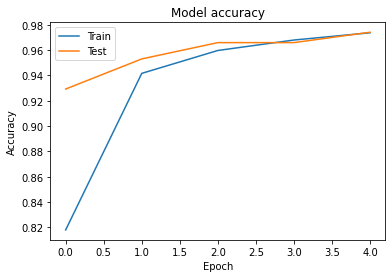

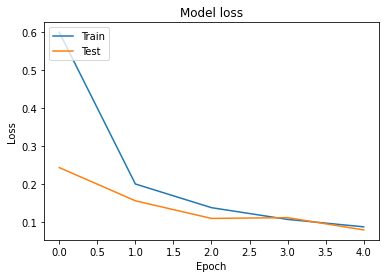

Time per epoch: [14.577337265014648, 7.952133417129517, 7.869463682174683, 7.737809419631958, 7.933710098266602]
Total time: 46.07045388221741


In [0]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [0]:
#Necessito di un array con tutte le labels
classes=[0,1,2,3,4,5,6,7,8,9]

test_predictions = model_CNN_LSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

[[ 962    0    1    0    3    3    0    4    5    2]
 [   0 1123    4    2    0    0    1    0    5    0]
 [   5    1 1005    5    2    1    1    6    6    0]
 [   0    0    4  986    0    7    0    6    6    1]
 [   2    0    2    2  944    0    4    1    2   25]
 [   2    0    0    6    0  873    3    1    6    1]
 [   2    2    3    1    2    2  939    0    6    1]
 [   0    4   19    2    1    0    0  990    4    8]
 [   4    0    1    3    3    5    0    4  953    1]
 [   4    3    2   10    5    5    1    7    5  967]]


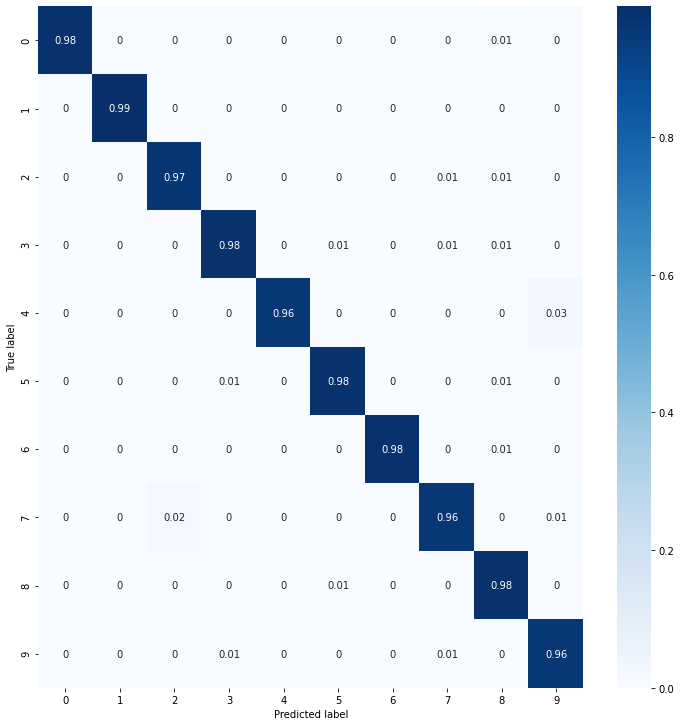

In [0]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Predizioni

In [0]:
predictions = model_CNN_LSTM.predict(test_images)

print("Done")

Done


In [0]:
train_images = train_images.reshape(60000, rows, cols)

test_images = test_images.reshape(10000, rows, cols)

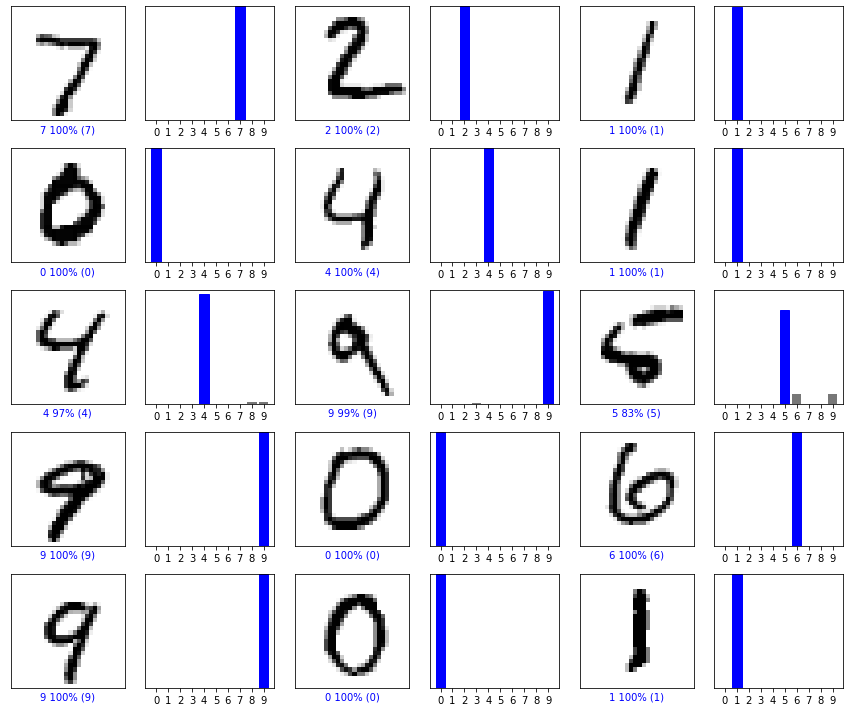

In [0]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()